### Natural Image Classification (Kaggle Challenge)

1. Download the dataset from https://www.kaggle.com/prasunroy/natural-images
2. This dataset contains 6,899 images from 8 distinct classes compiled from various sources
(see Acknowledgements). The classes include airplane, car, cat, dog, flower, fruit,
motorbike and person.
3. Design a suitable model to classify these images.
4. Randomly select 20% of the images as train set, train the model with the rest 80%
images. Report classification accuracy. Show some images that are correctly predicted.
Also, show some images that are not correctly predicted. Mention the true labels and the
predicted labels for these images.

***
***

## Import Modules

In [12]:
import numpy as np
import os
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import time
from tensorflow.keras import models , optimizers , losses ,activations
from tensorflow.keras.layers import *

from tensorflow.keras.callbacks import TensorBoard


## Load Dataset

In [3]:
dimen = 32

dir_path = 'natural_images/'
output_path = 'processed_data/'

sub_dir_list = os.listdir( dir_path )
images = list()
labels = list()
for i in range( len( sub_dir_list ) ):
    label = i
    image_names = os.listdir( dir_path + sub_dir_list[i] )
    for image_path in image_names:
        path = dir_path + sub_dir_list[i] + "/" + image_path
        image = Image.open( path ).convert( 'L' )
        resize_image = image.resize((dimen, dimen))
        array = list()
        for x in range(dimen):
            sub_array = list()
            for y in range(dimen):
                sub_array.append(resize_image.load()[x, y])
            array.append(sub_array)
        image_data = np.array(array)
        image = np.array(np.reshape(image_data, (dimen, dimen, 1))) / 255
        images.append(image)
        labels.append( label )

x = np.array( images )
y = np.array( keras.utils.to_categorical( np.array( labels) , num_classes=len(sub_dir_list) ) )

train_features , test_features ,train_labels, test_labels = train_test_split( x , y , test_size=0.4 )

np.save( '{}x.npy'.format( output_path )  , train_features )
np.save( '{}y.npy'.format( output_path )  , train_labels )
np.save( '{}test_x.npy'.format( output_path ) , test_features )
np.save( '{}test_y.npy'.format( output_path ) , test_labels )


## Create a Classifier Class

In [5]:
class Classifier (object) :

    def __init__( self , number_of_classes ):

        dropout_rate = 0.5
        self.__DIMEN = 32

        input_shape = ( self.__DIMEN**2 , )
        convolution_shape = ( self.__DIMEN , self.__DIMEN , 1 )
        kernel_size = ( 3 , 3 )
        pool_size = ( 2 , 2 )
        strides = 1

        activation_func = activations.relu

        self.__NEURAL_SCHEMA = [

            Reshape( input_shape=input_shape , target_shape=convolution_shape),

            Conv2D( 32, kernel_size=( 4 , 4 ) , strides=strides , activation=activation_func),
            MaxPooling2D(pool_size=pool_size, strides=strides ),

            Conv2D( 64, kernel_size=( 3 , 3 ) , strides=strides , activation=activation_func),
            MaxPooling2D(pool_size=pool_size , strides=strides),

            Flatten(),

            Dense( 100, activation=activation_func) ,
            Dropout(dropout_rate),

            Dense( number_of_classes, activation=tf.nn.softmax )

        ]

        self.__model = tf.keras.Sequential( self.__NEURAL_SCHEMA )

        self.__model.compile(
            optimizer=optimizers.Adam(),
            loss=losses.categorical_crossentropy ,
            metrics=[ 'accuracy' ] ,
        )

    def fit(self, X, Y  , hyperparameters):
        initial_time = time.time()
        self.__model.fit(X, Y,
                         batch_size=hyperparameters['batch_size'],
                         epochs=hyperparameters['epochs'],
                         callbacks=hyperparameters['callbacks'],
                         validation_data=hyperparameters['val_data']
                         )
        final_time = time.time()
        eta = (final_time - initial_time)
        time_unit = 'seconds'
        if eta >= 60:
            eta = eta / 60
            time_unit = 'minutes'
        self.__model.summary()
        print('Elapsed time acquired for {} epoch(s) -> {} {}'.format(hyperparameters['epochs'], eta, time_unit))

    def prepare_images_from_dir( self , dir_path ) :
        images = list()
        images_names = os.listdir( dir_path )
        for imageName in images_names :
            image = Image.open(dir_path + imageName).convert('L')
            resize_image = image.resize((self.__DIMEN, self.__DIMEN))
            array = list()
            for x in range(self.__DIMEN):
                sub_array = list()
                for y in range(self.__DIMEN):
                    sub_array.append(resize_image.load()[x, y])
                array.append(sub_array)
            image_data = np.array(array)
            image = np.array(np.reshape(image_data,(self.__DIMEN, self.__DIMEN, 1)))
            images.append(image)

        return np.array( images )

    def evaluate(self , test_X , test_Y  ) :
        return self.__model.evaluate(test_X, test_Y)

    def predict(self, X  ):
        predictions = self.__model.predict( X  )
        return predictions

    def save_model(self , file_path ):
        self.__model.save(file_path )

    def load_model(self , file_path ):
        self.__model = models.load_model(file_path)


## Tarin Classifier

In [6]:
data_dimension = 32

X = np.load( 'processed_data/x.npy'.format( data_dimension ))
Y = np.load( 'processed_data/y.npy'.format( data_dimension ))
test_X = np.load( 'processed_data/test_x.npy'.format( data_dimension ))
test_Y = np.load( 'processed_data/test_y.npy'.format( data_dimension ))

print( X.shape )
print( Y.shape )
print( test_X.shape )
print( test_Y.shape )

X = X.reshape( ( X.shape[0] , data_dimension**2  ) ).astype( np.float32 )
test_X = test_X.reshape( ( test_X.shape[0] , data_dimension**2 ) ).astype( np.float32 )

classifier = Classifier( number_of_classes=8 )
classifier.load_model( 'models/model.h5')

parameters = {
    'batch_size' : 250 ,
    'epochs' : 10 ,
    'callbacks' : None ,
    'val_data' : None
}

classifier.fit( X , Y  , hyperparameters=parameters )
classifier.save_model( 'models/model.h5')

loss , accuracy = classifier.evaluate( test_X , test_Y )

(4139, 32, 32, 1)
(4139, 8)
(2760, 32, 32, 1)
(2760, 8)
Epoch 1/10
4139/4139 [==============================] - 3s 661us/step - loss: 0.3054 - acc: 0.9099
Epoch 2/10
4139/4139 [==============================] - 1s 171us/step - loss: 0.2511 - acc: 0.9169
Epoch 3/10
4139/4139 [==============================] - 1s 159us/step - loss: 0.2170 - acc: 0.9258
Epoch 4/10
4139/4139 [==============================] - 1s 164us/step - loss: 0.1903 - acc: 0.9362
Epoch 5/10
4139/4139 [==============================] - 1s 161us/step - loss: 0.1718 - acc: 0.9379
Epoch 6/10
4139/4139 [==============================] - 1s 160us/step - loss: 0.1554 - acc: 0.9461
Epoch 7/10
4139/4139 [==============================] - 1s 160us/step - loss: 0.1586 - acc: 0.9435
Epoch 8/10
4139/4139 [==============================] - 1s 161us/step - loss: 0.1496 - acc: 0.9437
Epoch 9/10
4139/4139 [==============================] - 1s 159us/step - loss: 0.1396 - acc: 0.9505
Epoch 10/10
4139/4139 [==============================

## Prediction with Test Data

In [7]:
print( "Loss of {}".format( loss ) , "Accuracy of {} %".format( accuracy * 100 ) )

pred_Y =  classifier.predict( test_X ).argmax( 1 ) 

Loss of 0.2120695508044699 Accuracy of 92.8623188405797 %


In [8]:
print(test_Y.argmax(1))

[5 0 3 ... 2 0 1]


In [9]:
cm = confusion_matrix(test_Y.argmax(1), pred_Y)

In [10]:
class_name = np.unique(labels)

In [11]:
class_name

array([0, 1, 2, 3, 4, 5, 6, 7])

### Plotting the prediction

In [13]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

### Confusion Matrix

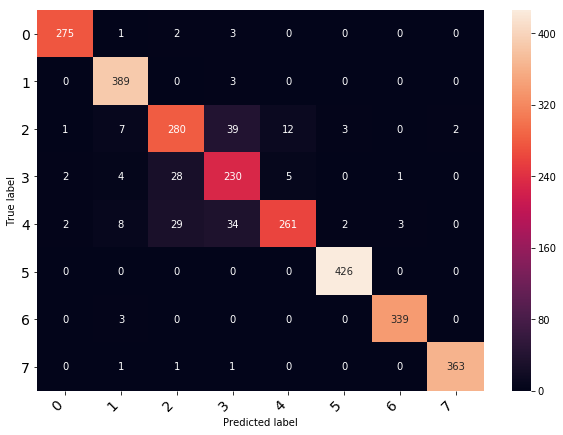

In [14]:
print_confusion_matrix(cm, class_name)